In [1]:
import pandas as pd
import os
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import multiprocessing
from shapely.geometry import Point, LineString

data_dir = os.path.join("../../data/embeddings/")
imd_file = os.path.join("../../", "data", "imd", "File_2_-_IoD2025_Domains_of_Deprivation.xlsx")

var_to_predict = 'imd_rank'

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def evaluate_imd_model(y_true, y_pred, column, plot=True, plot_collectively = False, ax=False ):

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)

    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Spearman_rank_corr': spearman_corr}

    # Scatter plot
    if plot:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.scatter(y_true, y_pred, alpha=0.7)
        ax.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)

        ax.set_xlabel(f"True")
        ax.set_ylabel(f"Predicted")
        ax.set_title(f"{column}")
        ax.grid(True)

        # Annotate with R² and RMSE using axes coordinates (0–1)
        ax.text(0.01, 0.99,
            f'R² = {r2:.2f},  Spearman = {spearman_corr:.2f},\nRMSE = {rmse:.0f}, MAE = {mae:.0f}',
            transform=ax.transAxes,fontsize=12, verticalalignment='top', horizontalalignment='left')
        plt.show()

    # Scatter plot
    if plot_collectively:
        ax.scatter(y_true, y_pred, alpha=0.7)
        ax.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
        ax.set_xlabel(f"True")
        ax.set_ylabel(f"Predicted")
        ax.set_title(f"{column}", fontsize=15)
        ax.grid(True)
        ax.text(
            0.01, 0.99,  # x=1% from left, y=99% from bottom
            f'R² = {r2:.2f}, RMSE = {rmse:.0f}, MAE = {mae:.0f}, Spearman = {Spearman_rank_corr:.2f}',
            transform=ax.transAxes,  # use axes coordinates
            fontsize=12,
            verticalalignment='top',  # anchor to top so it doesn’t go outside
            horizontalalignment='left')
    
    return metrics

Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.


### Get imd data

In [2]:
imd = pd.read_excel(imd_file, sheet_name="IoD2025 Domains", header=0)

# Rename columns to simpler versions
imd_col_map = {"LSOA code (2021)": "LSOA21CD",
    "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "imd_rank",
    "Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)": "imd_decile"}
imd = imd.rename(columns=imd_col_map)

In [3]:
# Define Manchester city centre point (in WGS84, then project)
city_centre_wgs84 = Point(-2.2426, 53.4808)  # approx lat/lon of Manchester city centre
city_centre_point = gpd.GeoSeries([city_centre_wgs84], crs='EPSG:4326').to_crs(epsg=27700).iloc[0]

# Filter polygons within a buffer distance (e.g., 3 km radius)
buffer = city_centre_point.buffer(6000)  # 3000 meters

# Get lsoas data
lsoas_file = os.path.join("../../data/SpatialData/", "LSOAs_2011", "LSOA_2011_EW_BSC_V4.shp")
lsoas =  gpd.read_file(lsoas_file)
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
manc_lads_pattern = '|'.join(manc_lads)
gm_lsoa=lsoas[lsoas['LSOA11NMW'].str.contains(manc_lads_pattern)].copy()

## Trim to those within buffer
central_lsoas = gm_lsoa[gm_lsoa.intersects(buffer)]
central_lsoas.reset_index(inplace=True)
central_lsoas = central_lsoas.to_crs(epsg=4326)

# 1. Using mean embedding at each location
### Get data 

In [5]:
# avg_embeddings_per_location = pd.read_pickle(data_dir +"mean_embeddings_per_location.pkl")
# avg_embeddings_per_location_with_imd = pd.merge(left=avg_embeddings_per_location, right=imd, on="LSOA11CD")

### Build model

In [6]:
# X = np.stack(avg_embeddings_per_location_with_imd["mean_embedding"].values)     # shape (n_points, embed_dim)
# y = avg_embeddings_per_location_with_imd['imd_rank'].values

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Fit a model (Random Forest Regressor example)
# rf = RandomForestRegressor(n_estimators=200, random_state=42)
# rf.fit(X_train, y_train)

# # Predict and evaluate
# y_pred = rf.predict(X_test)

# # Usage example:
# metrics = evaluate_imd_model(y_test, y_pred)

# 2. Using mean embedding per LSOA, based on mean each location

### Get data

In [5]:
mean_embeddings = pd.read_pickle(data_dir +"mean_embeddings_per_lsoa.pkl")
# mean_embeddings = mean_embeddings.merge(central_lsoas, on ='LSOA11CD')[['LSOA11CD', 'mean_embedding']]
mean_embeddings_with_imd = pd.merge(left=mean_embeddings, right=imd, on="LSOA21CD")
mean_embeddings_with_imd['imd_rerank'] = mean_embeddings_with_imd['imd_rank'].rank(method='first').astype(int)

### Build model

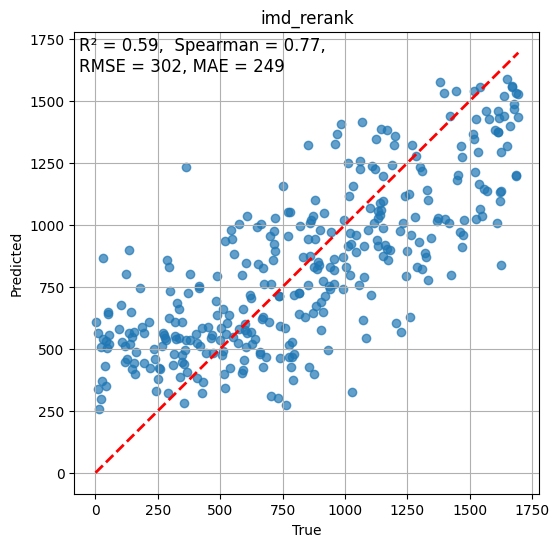

In [6]:
X = np.stack(mean_embeddings_with_imd["mean_embedding"].values)     # shape (n_points, embed_dim)
y = mean_embeddings_with_imd['imd_rerank'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a model (Random Forest Regressor example)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)

# Usage example:
metrics = evaluate_imd_model(y_test, y_pred, 'imd_rerank', plot=True, plot_collectively = False, ax=False)

## Test model performance on specific types of images

In [ ]:
k = 9  # e.g., parks, houses, roads, industrial, water
kmeans = KMeans(n_clusters=k, random_state=42)
all_embeddings = np.stack(expanded_gdf['embedding'].values)
expanded_gdf['scene_cluster'] = kmeans.fit_predict(all_embeddings)